In [42]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from model import InvertedPendulum, massSpringDamper
import matplotlib.animation as animation
from functools import partial
from IPython import display 

In [43]:
class PID_controller():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd

    def action(self, error, errorDot, errorInt):
        return self.kp*error + self.ki*errorInt + self.kd*errorDot
    
class stateFeedback_controller():
    def __init__(self, gain):
        self.gain = gain
    
    def action(self, state):
        return np.dot(self.gain, state)
    
def update(frame, theta_arr, pendCen, pendLen, line): #function for creating animation
    theta = theta_arr[frame]
    x = [pendCen[0], pendCen[0] - pendLen*np.sin(theta)]
    z = [pendCen[1], pendCen[1] - pendLen*np.cos(theta)]
    line.set_xdata(x)
    line.set_ydata(z)
    return line

In [46]:
def main():
    m_msd = 1
    c_msd = 1
    k_msd = 1
    m_ivp = 1
    k_ivp = 1
    l_ivp = 1
    g = 9.8

    mass_spring_damper = massSpringDamper(m_msd, c_msd, k_msd)

    inverted_pendulum = InvertedPendulum(m_ivp, l_ivp, g, k_ivp)

    pid_controller = PID_controller(10,5,0)

    sim_time = 10

    sim_dt = 0.05
    
    theta_0 = 10*np.pi/180
    theta_T = np.pi
    omega_0, omega_T = 0,0

    #implementing PID
    error_p = 0
    theta = theta_0
    omega = omega_0
    theta_array = [theta]
    omega_array = [omega]
    error_int = 0
    time_array = [0]
    u_pid_array = []
    error_array = []
    for time in np.arange(0, sim_time, sim_dt):
        error = theta_T - theta
        error_dot = (error - error_p)/sim_dt
        error_int += error*sim_dt
        u_pid = pid_controller.action(error, error_dot, error_int)
        theta_next, omega_next = inverted_pendulum.nextState([theta, omega], u_pid, sim_dt)
        theta, omega = theta_next, omega_next
        theta_array.append(theta)
        omega_array.append(omega)
        time_array.append(time+sim_dt)
        u_pid_array.append(u_pid)
        error_array.append(error)

    plt.figure(1)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, theta_array)
    ax1.title.set_text('theta')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array, omega_array)
    ax2.title.set_text('omega')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:-1], u_pid_array)
    ax3.title.set_text('control')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:-1], error_array)
    ax4.title.set_text('error')

    #implementing state feedback assuming full state is available

    x_T = np.array([[theta_T],[omega_T]])
    x_0 = np.array([[theta_0],[omega_0]])
    omega_array_sf = [omega_0]
    theta_array_sf = [theta_0]
    #x_array_sf = [x_0]
    x_array_sf = np.zeros((2, int(sim_time/sim_dt+1)))
    x_array_sf[0,0] = x_0[0,0]
    x_array_sf[1,0] = x_0[1,0]
    u_sf_array = []
    error_sf_array = []
    x = np.copy(x_0)
    for time in np.arange(0, sim_time, sim_dt):
        A_mat = inverted_pendulum.AMatt(x[0,0])
        B_mat = inverted_pendulum.BMatt()
        poles = np.array([-10,-25])
        K_mat = sc.signal.place_poles(A_mat, B_mat, poles).gain_matrix
        u_ss = inverted_pendulum.m*g*inverted_pendulum.l/2*np.cos(x[0,0])*(x_T[0,0] - x[0,0])
        #print('u_ss - ', u_ss, 'K_mat - ',  K_mat, 'diff - ', x_T - x)
        u_tot = u_ss + np.dot(K_mat,(x_T - x))[0,0]
        # print('mat prod', np.dot(K_mat,(x_T - x))[0,0])
        # print('u_tot', u_tot[0, 0])
        
        theta_next, omega_next = inverted_pendulum.nextState([x[0,0], x[1,0]], u_tot, sim_dt)
        theta_array_sf.append(theta_next)
        omega_array_sf.append(omega_next)
        u_sf_array.append(u_tot)
        error_sf_array.append(theta_T - theta_next)
        if theta_next == 0:
            print('fuck')
        x = np.array([[theta_next], [omega_next]])
        if x[0,0] == 0:
            print('wtf')
        #print(int(time/sim_dt + 1))
        x_array_sf[0,int(time/sim_dt + 1)] = x[0,0]
        x_array_sf[1,int(time/sim_dt + 1)] = x[1,0]    
        #x_array_sf.append(x)
    #print('theta_sf', x_array_sf[0,:])
    plt.figure(2)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, theta_array_sf)
    ax1.title.set_text('theta')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array,  omega_array_sf)
    ax2.title.set_text('omega')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:-1], u_sf_array)
    ax3.title.set_text('control')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:-1], error_sf_array)
    ax4.title.set_text('error')


    #creating animation
    fig, ax = plt.subplots()
    pendCent = [5,5]
    offset = [-l_ivp*np.sin(theta_0), -l_ivp*np.sin(theta_0)]
    pendEnd = pendCent + offset

    line = ax.plot([pendCent[0], pendEnd[0]], [pendCent[1], pendEnd[1]])[0]

    ax.set(xlim = [0,10], ylim = [0,10], xlabel = "x", ylabel = "z")

    ani = animation.FuncAnimation(fig=fig, func=partial(update, theta_arr = theta_array, pendCen = pendCent, pendLen = l_ivp*2, line = line), frames=int(sim_time/sim_dt), interval = int(sim_dt*1000))
    #writervideo = animation.FFMpegWriter(fps=60) 
    ani.save('Invpend.gif')#, writer=writervideo) 
    plt.close
    # plt.show()
    # video = ani.to_html5_video() 
  
    # # embedding for the video 
    # html = display.HTML(video) 
    
    # display.display(html) 
    # plt.close()

    
        
        

    

MovieWriter ffmpeg unavailable; using Pillow instead.


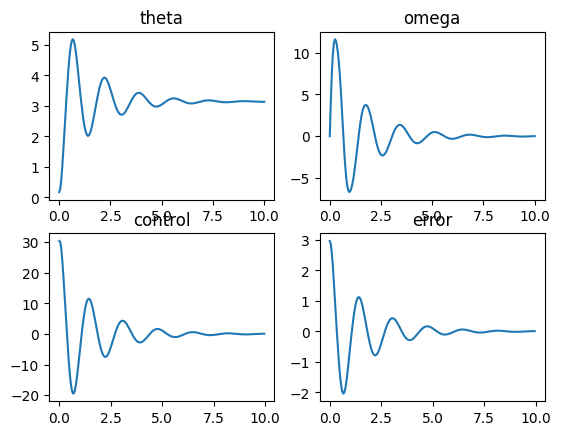

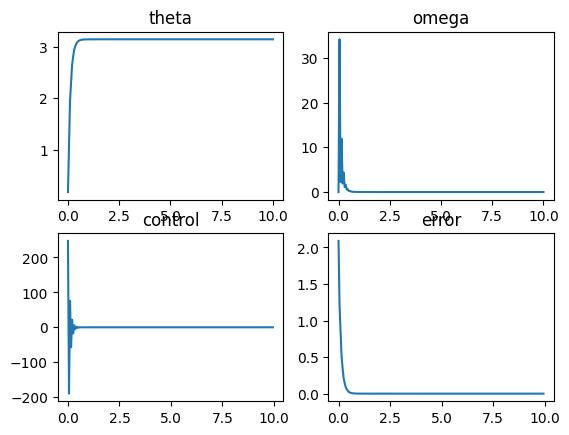

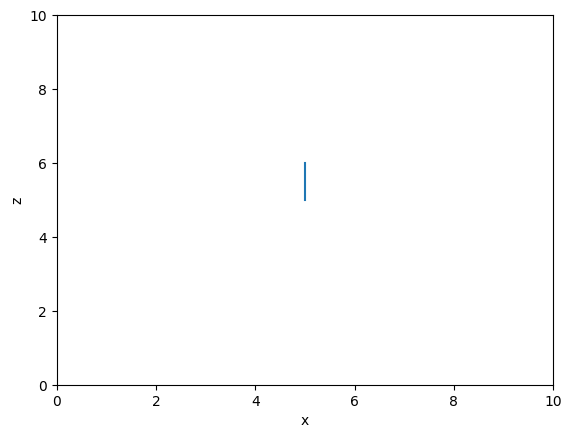

In [47]:
if __name__ == '__main__':
    main()
    

NameError: name 'l_ivp' is not defined

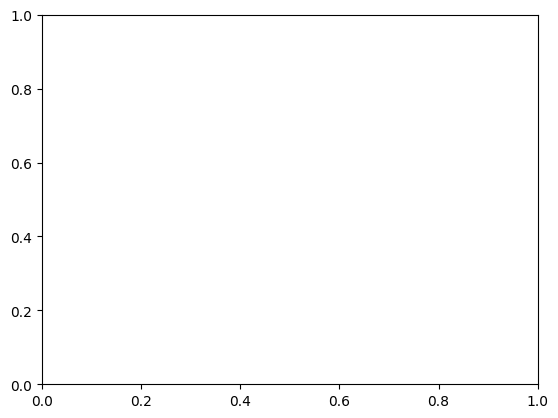

In [6]:
#creating animation from the output data
fig, ax = plt.subplots()
pendCent = [5,5]
offset = [-l_ivp*np.sin(theta_0), -l_ivp*np.sin(theta_0)]
pendEnd = pendCent + offset

line = ax.plot([pendCent[0], pendEnd[0]], [pendCent[1], pendEnd[1]])

ax.set(xlim = [0,10], ylim = [0,10], xlabel = "x", ylabel = "z")

def update(frame):
    theta = theta_array_sf[frame]
    line.set_xdata()

In [41]:
# importing required libraries 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.animation as animation 
from IPython import display 

# initializing a figure 
fig = plt.figure() 

# labeling the x-axis and y-axis 
axis = plt.axes(xlim=(0, 1000), ylim=(0, 1000)) 

# lists storing x and y values 
x, y = [], [] 

line, = axis.plot(0, 0) 


def animate(frame_number): 
	x.append(frame_number) 
	y.append(frame_number) 
	line.set_xdata(x) 
	line.set_ydata(y) 
	return line, 


anim = animation.FuncAnimation(fig, animate, frames=1000, 
							interval=20, blit=True) 
fig.suptitle('Straight Line plot', fontsize=14) 

# saving to m4 using ffmpeg writer 
writervideo = animation.FFMpegWriter(fps=60) 
anim.save('increasingStraightLine.gif')#, writer=writervideo) 
plt.close() 


MovieWriter ffmpeg unavailable; using Pillow instead.


RuntimeError: Requested MovieWriter (ffmpeg) not available

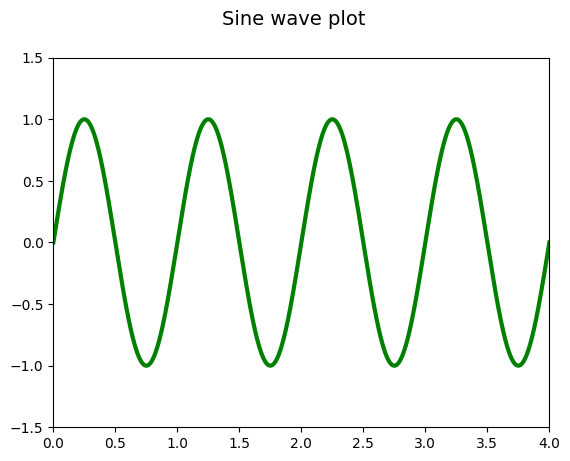

In [38]:
# importing required libraries 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.animation as animation 
from IPython import display 

# initializing a figure 
fig = plt.figure() 

# labeling the x-axis and y-axis 
axis = plt.axes(xlim=(0, 4), ylim=(-1.5, 1.5)) 

# initializing a line variable 
line, = axis.plot([], [], lw=3) 

def animate(frame_number): 
	x = np.linspace(0, 4, 1000) 

	# plots a sine graph 
	y = np.sin(2 * np.pi * (x - 0.01 * frame_number)) 
	line.set_data(x, y) 
	line.set_color('green') 
	return line, 


anim = animation.FuncAnimation(fig, animate, frames=100, 
							interval=20, blit=True) 
fig.suptitle('Sine wave plot', fontsize=14) 

# converting to an html5 video 
video = anim.to_html5_video() 

# embedding for the video 
html = display.HTML(video) 

# draw the animation 
display.display(html) 
plt.close() 
